# Project 3 - Malav Shah

# Time Series Analysis Predicting Spot Exchange for Euros into USD

## 1. Importing Required Libraries

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## 2. Importing Data

In [2]:
df_fx_data = pd.read_csv('BOE-XUDLERD_FINAL.csv')
prices = pd.read_csv("BOE-XUDLERD_FINAL.csv")

The dataset above is imported in two different data frames to perform seperate analysis for daily and weekly data converting one of them to weekly data frame which is shown further below.

In [3]:
print(prices.head())

         Date   Value
0  31-12-2020  0.8146
1  30-12-2020  0.8129
2  29-12-2020  0.8168
3  24-12-2020  0.8200
4  23-12-2020  0.8205


Converting the date to required format in the data frames

In [4]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'], format = '%d-%m-%Y')
indexed_df = df_fx_data.set_index('Date')

In [5]:
ts_euro = indexed_df['Value']
ts_euro.head(5)

Date
2020-12-31    0.8146
2020-12-30    0.8129
2020-12-29    0.8168
2020-12-24    0.8200
2020-12-23    0.8205
Name: Value, dtype: float64

In [6]:
prices.index = pd.to_datetime(prices['Date'], format='%d-%m-%Y')
del prices['Date']
prices.head()

,Value
Date,
2020-12-31,0.8146
2020-12-30,0.8129
2020-12-29,0.8168
2020-12-24,0.8200
2020-12-23,0.8205


## 3. Performing Visualisations and Analysis of Time Series

Plotting the time series

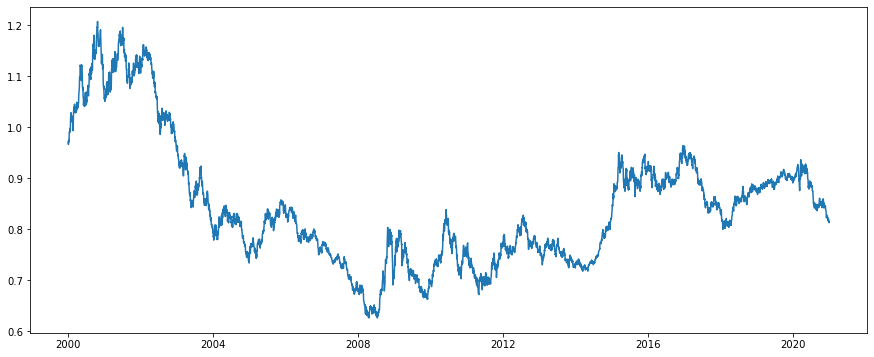

In [7]:
plt.plot(ts_euro.index.to_pydatetime(), ts_euro.values)

Converting the daily time series to weekly with mean of the weekly values

In [8]:
ts_euro_week = ts_euro.resample('W').mean()

Plotting the time series conevrted to weekly

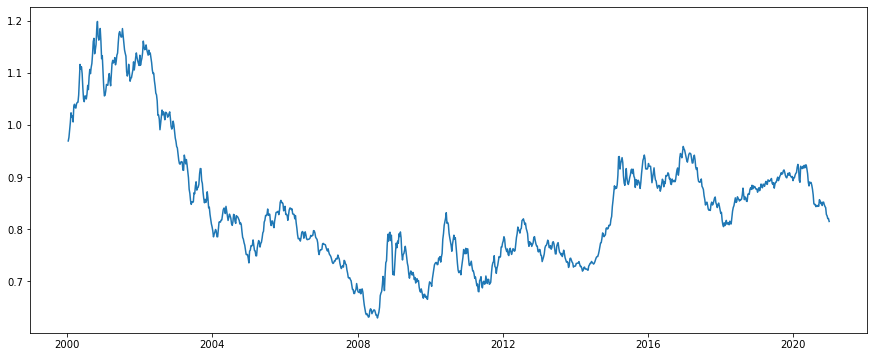

In [9]:
plt.plot(ts_euro_week.index.to_pydatetime(), ts_euro_week.values)

## 4. Checking the stationarity of the Time Series

A stationary time series is a series where stastical properties are constant over the time and auto covariance is time independent. The two methods used below to check the stationarity are:

1. plotting the moving variance and observing if it remains constant over time
2. Dickey-Fuller Test

In [10]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

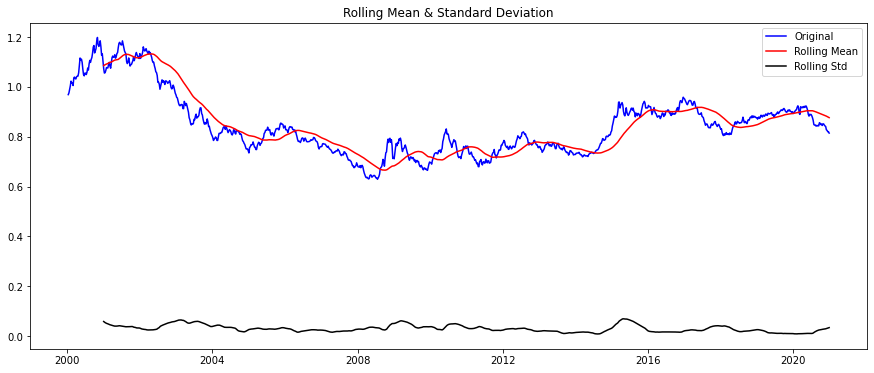

Results of Dickey-Fuller Test:
Test Statistic                   -1.925496
p-value                           0.320164
#Lags Used                        5.000000
Number of Observations Used    1090.000000
Critical Value (1%)              -3.436364
Critical Value (5%)              -2.864195
Critical Value (10%)             -2.568184
dtype: float64


In [11]:
check_stationarity(ts_euro_week)

The above results show that test statistic is much greater than the Critical Value and p-value is also larger then 0.05 hence the weekly time series is not statioanry. 

First method we can use to stationarise a time series is applying a non linear log tranformation as below.

In [12]:
ts_euro_week_log = np.log(ts_euro_week)

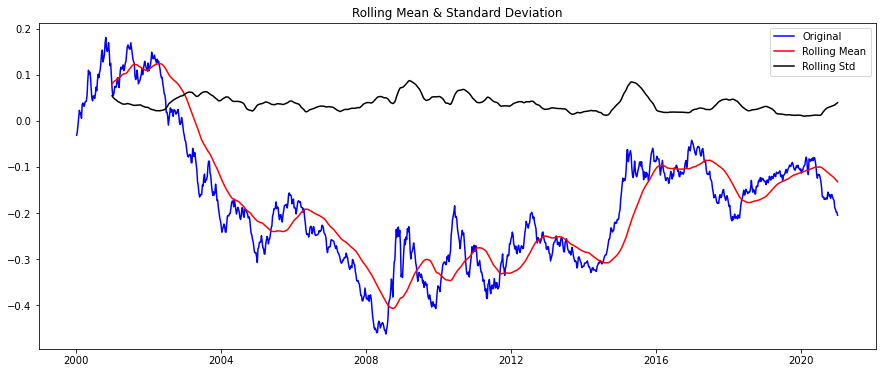

Results of Dickey-Fuller Test:
Test Statistic                   -1.917897
p-value                           0.323689
#Lags Used                        3.000000
Number of Observations Used    1092.000000
Critical Value (1%)              -3.436353
Critical Value (5%)              -2.864190
Critical Value (10%)             -2.568181
dtype: float64


In [13]:
check_stationarity(ts_euro_week_log)

After applying the non linear log tranformation we can see that the p-value has improved and test statistic value has also improved but still the results indicate that the series is not stationary. Hence, we can try to remove trends and seasonality with the help of decomposition.

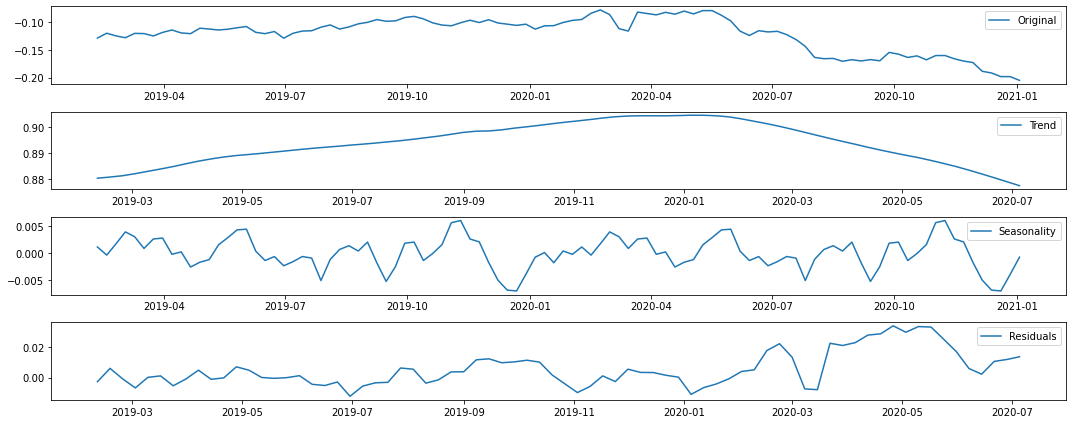

In [14]:
decomposition = seasonal_decompose(ts_euro_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent weeks 
ts_euro_week_log_select = ts_euro_week_log[-100:]

plt.subplot(411)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), ts_euro_week_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), trend[-100:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), seasonal[-100:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), residual[-100:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

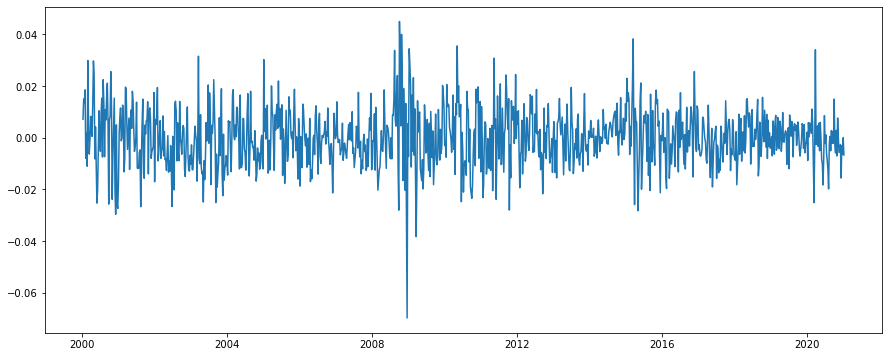

In [15]:
ts_euro_week_log_diff = ts_euro_week_log - ts_euro_week_log.shift()
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)

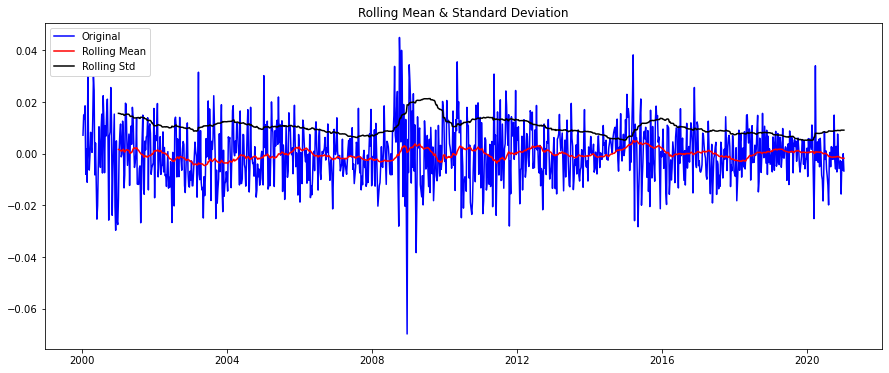

Results of Dickey-Fuller Test:
Test Statistic                -1.696514e+01
p-value                        9.246319e-30
#Lags Used                     2.000000e+00
Number of Observations Used    1.092000e+03
Critical Value (1%)           -3.436353e+00
Critical Value (5%)           -2.864190e+00
Critical Value (10%)          -2.568181e+00
dtype: float64


In [16]:
ts_euro_week_log_diff.dropna(inplace=True)
check_stationarity(ts_euro_week_log_diff)

After performing the decomposition of weekly time series we can see that the p-value is much larger and test- statistic also has not improved. Hence we can use daily time series for predictions for better results.

## 5. Plotting Auto Coorelation and Partial Auto Coorelation Function

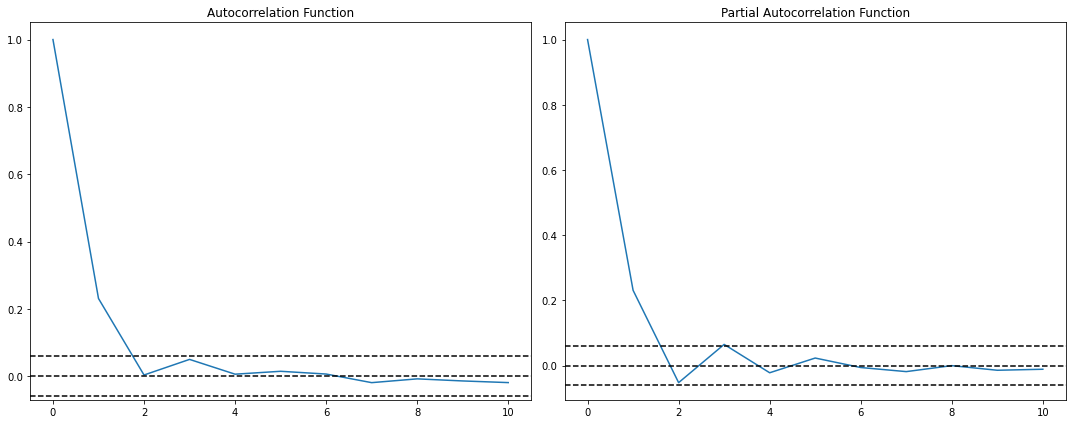

In [17]:
#ACF and PACF plots

lag_auto_corr = acf(ts_euro_week_log_diff, nlags=10)
lag_par_auto_corr = pacf(ts_euro_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## 6. Decomposition of Daily TIme Series

In [18]:
df = prices[['Value']]
decompose_data = seasonal_decompose(df, model="additive", period=365)

Plotting seasonality, trend and residue for daily time series

<AxesSubplot:xlabel='Date'>

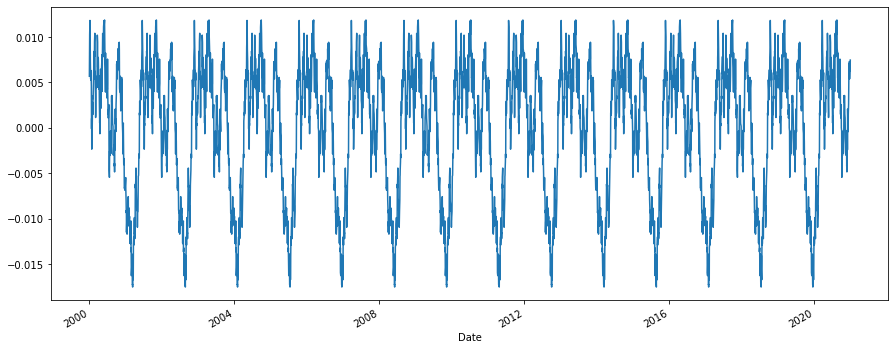

In [19]:
decompose_data.seasonal.plot()

<AxesSubplot:xlabel='Date'>

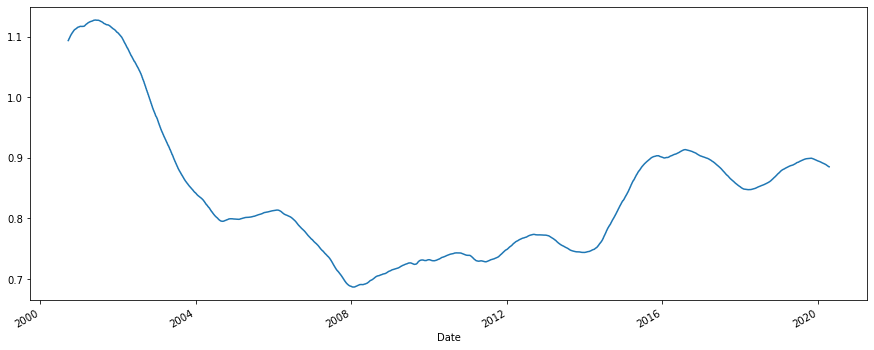

In [20]:
decompose_data.trend.plot()

<AxesSubplot:xlabel='Date'>

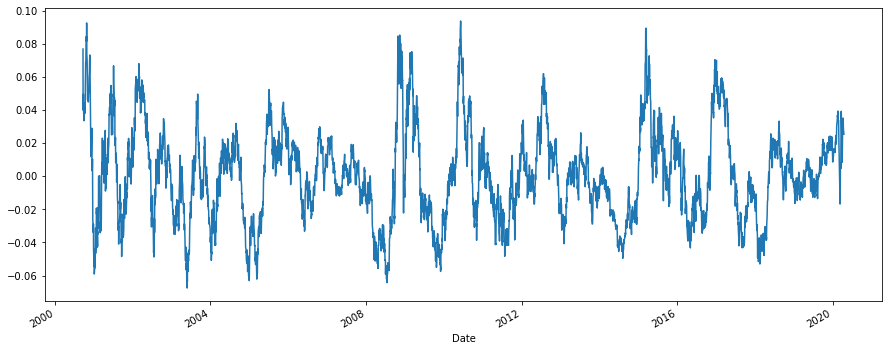

In [21]:
decompose_data.resid.plot()

## 7. Build, Tune and Train ARIMA and SARIMA Models

Splitting the time series into test and train data and visualising it

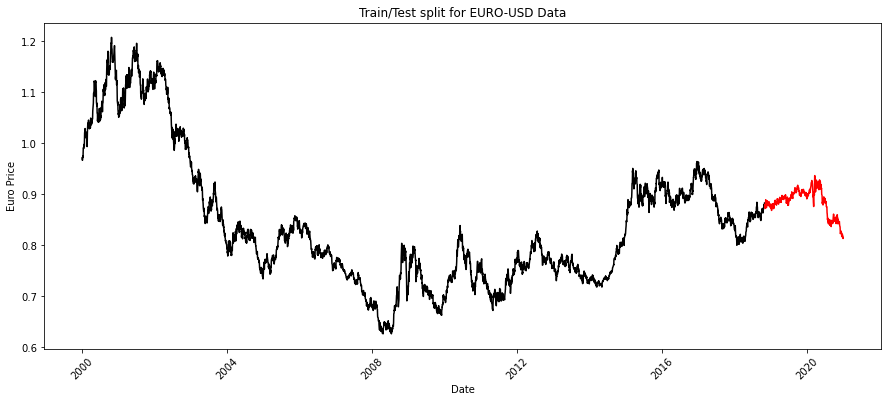

In [22]:
train = prices[prices.index < pd.to_datetime("2018-11-01", format='%Y-%m-%d')]
test = prices[prices.index > pd.to_datetime("2018-11-01", format='%Y-%m-%d')]

plt.plot(train.index, train['Value'], color = "black")
plt.plot(test.index, test['Value'], color = "red") 
plt.ylabel('Euro Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for EURO-USD Data")
plt.show()

In [23]:
# Defining the ARIMA Model
y = train['Value']

ARIMAmodel = ARIMA(y, order = (2, 1, 2))
# The first parameter corresponds to the lagging (past values), 
# the second corresponds to differencing (this is what makes 
# non-stationary data stationary), and the last parameter corresponds 
# to the white noise (for modeling shock events)
# Here in deciding the order ACF and PACF values are also considered
ARIMAmodel = ARIMAmodel.fit()

y_pred_2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_2 = y_pred_2.conf_int(alpha = 0.05) #--higher alpha assigns greater weight to more recent values
y_pred_df_2["Predictions"] = ARIMAmodel.predict(start = y_pred_df_2.index[0], end = y_pred_df_2.index[-1])
y_pred_df_2.index = test.index
y_pred_out_2 = y_pred_df_2["Predictions"]


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-

In [24]:
# Defining SARIMA Model
y = train['Value']

SARIMAXmodel = SARIMAX(y, order = (2, 1, 2), seasonal_order=(2,2,2,3))
#SARIMAXmodel = SARIMAX(y, order = (2, 1, 2))
# The first 3 parameters for seasonal_order are defined the same as when treating non-seasonal
# The fourth indicates the seasonal periods to apply the parameters to
# In other words, how many observations of seasonal spikes/dips per year 
SARIMAXmodel = SARIMAXmodel.fit()

y_pred_3 = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df_3 = y_pred_3.conf_int(alpha = 0.05) 
y_pred_df_3["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_3.index[0], end = y_pred_df_3.index[-1])
y_pred_df_3.index = test.index
y_pred_out_3 = y_pred_df_3["Predictions"] 

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-

SARIMA RMSE:  0.2288214437125827
ARIMA RMSE:  0.0895597425218009


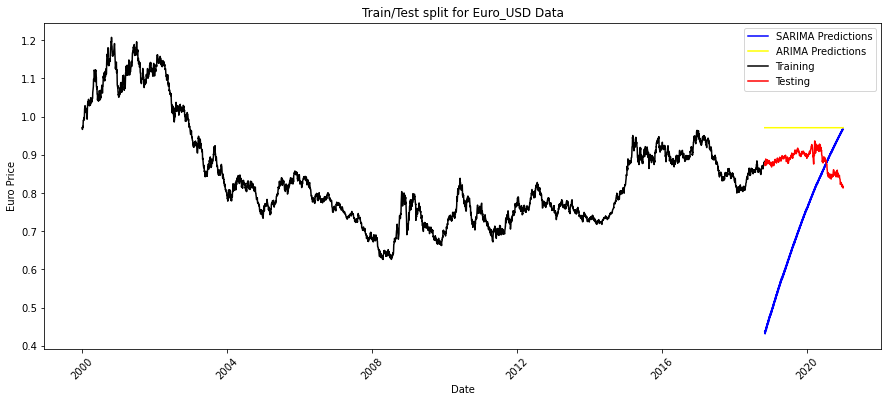

In [25]:
plt.plot(y_pred_out_3, color='Blue', label = 'SARIMA Predictions')
plt.plot(y_pred_out_2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train.index, train['Value'], color = "black", label = 'Training')
plt.plot(test.index, test['Value'], color = "red", label = 'Testing')
plt.ylabel('Euro Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Euro_USD Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["Value"].values, y_pred_df_3["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test["Value"].values, y_pred_df_2["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)


The above results show a good RMSE value but we can still fine tune our model for better predictions. However, since the exhang rate data does not show much seasonality SARIMA model without seasonality gave the same results as ARIMA and keeping the seasonality to minimum gave more inaccurate results.

Fine Tuning the ARIMA Model.

To improve the accuracy for ARIMA model the ordering parameters were adjusted and the model was trained again for the below results.

In [25]:
# Lets define our model input
y = train['Value']

ARIMAmodel = ARIMA(y, order = (1, 2, 2))
# The first parameter corresponds to the lagging (past values), 
# the second corresponds to differencing (this is what makes 
# non-stationary data stationary), and the last parameter corresponds 
# to the white noise (for modeling shock events)
ARIMAmodel = ARIMAmodel.fit()

y_pred_4 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_4 = y_pred_4.conf_int(alpha = 0.05) #--higher alpha assigns greater weight to more recent values
y_pred_df_4["Predictions"] = ARIMAmodel.predict(start = y_pred_df_4.index[0], end = y_pred_df_4.index[-1])
y_pred_df_4.index = test.index
y_pred_out_4 = y_pred_df_4["Predictions"]

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\lib\site-

SARIMA RMSE:  0.2288214437125827
ARIMA RMSE:  0.05793117710601206


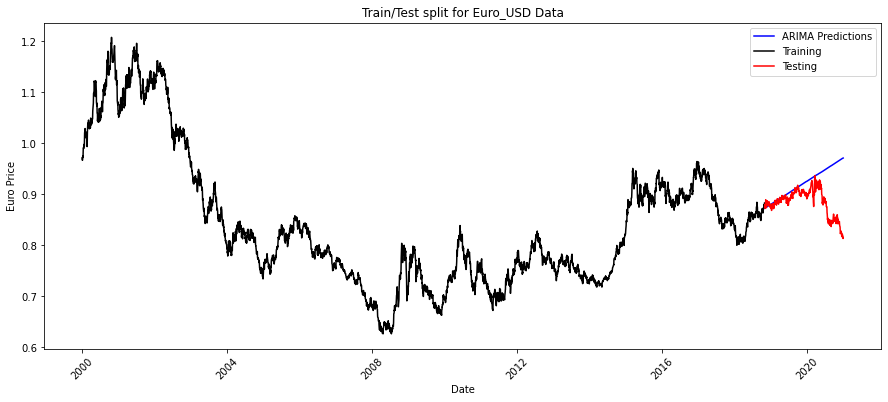

In [26]:
plt.plot(y_pred_out_4, color='Blue', label = 'ARIMA Predictions')
plt.plot(train.index, train['Value'], color = "black", label = 'Training')
plt.plot(test.index, test['Value'], color = "red", label = 'Testing')
plt.ylabel('Euro Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Euro_USD Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["Value"].values, y_pred_df_3["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test["Value"].values, y_pred_df_4["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)


The above predictions are much more accurate than it was before tuning the order. Hence we can say that fine tuning the order of the modele gave better reults. But we can still have much more accurate predictions using other time series models. Below is the final summary of the ARIMA Model Used.

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 4760
Model:                 ARIMA(1, 2, 2)   Log Likelihood               18151.572
Date:                Wed, 14 Dec 2022   AIC                         -36295.144
Time:                        17:29:36   BIC                         -36269.274
Sample:                             0   HQIC                        -36286.054
                               - 4760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9861      0.020    -48.946      0.000      -1.026      -0.947
ma.L1         -0.0170      0.106     -0.160      0.873      -0.225       0.191
ma.L2         -0.9829      0.107     -9.159      0.0

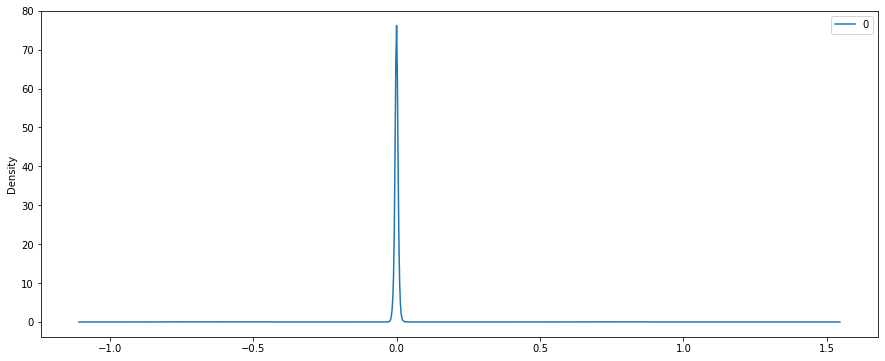

In [56]:
print(ARIMAmodel.summary())
residuals = DataFrame(ARIMAmodel.resid)
residuals.plot(kind='kde')
print(residuals.describe())

## 8. Implementing FB Prophet Model for TIme Series Analysis

In [29]:
from prophet import Prophet

In [30]:
df_prophet = pd.read_csv('BOE-XUDLERD_FINAL.csv')
df_prophet.head()

,Value
Date,
2020-12-31,0.8146
2020-12-30,0.8129
2020-12-29,0.8168
2020-12-24,0.8200
2020-12-23,0.8205


In [34]:
df_prophet= df_prophet.rename(columns={'Date':'ds','Value':'y'})

In [36]:
m = Prophet()
m.fit(df_prophet)

C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '31-12-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '30-12-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '29-12-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '24-12-2020' in D

C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '30-09-2005' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '29-09-2005' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '28-09-2005' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:1117: UserWarning: Parsing '27-09-2005' in D

C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '28-05-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '24-05-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '23-05-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '22-05-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-pa

C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '22-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '19-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '18-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '17-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-pa

C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '15-01-2002' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '14-01-2002' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '31-12-2001' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-packages\prophet\forecaster.py:270: UserWarning: Parsing '28-12-2001' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
C:\Users\ADMIN\anaconda3\lib\site-pa

13:08:13 - cmdstanpy - INFO - Chain [1] start processing
13:08:24 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5670,2021-12-27
5671,2021-12-28
5672,2021-12-29
5673,2021-12-30
5674,2021-12-31


In [38]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
5670,2021-12-27,0.859539,0.799260,0.918103
5671,2021-12-28,0.860000,0.799667,0.925491
5672,2021-12-29,0.859534,0.803331,0.915004
5673,2021-12-30,0.857670,0.801169,0.917202
5674,2021-12-31,0.860408,0.800682,0.919603


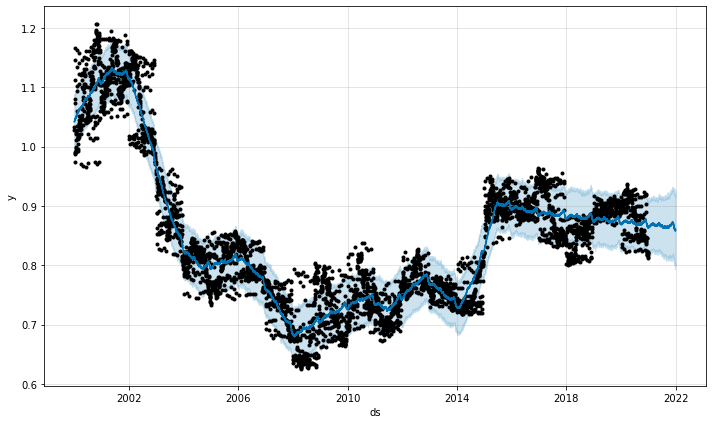

In [39]:
fig1 = m.plot(forecast)

The above graph indicates the predictions made by FB Prophet Model against the actual values. The values are very close the actual values and hence we can say that the model made very accurate predictions.

Plotting the forecasting overall trend, weekly component and monthly component.

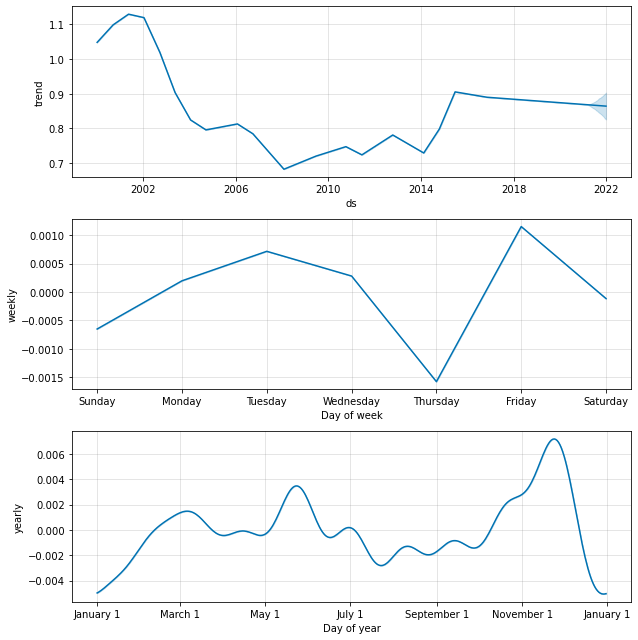

In [40]:
fig2 = m.plot_components(forecast)

Calculating the RMSE Value for FB Prophet Model

In [45]:
y_true =df_prophet['y']
y_pred = forecast['yhat']

In [49]:
def mean_squared_error(y_true,y_pred):
    mse=np.mean((y_true - y_pred)**2)
    return mse

In [50]:
mean_squared_error(y_true,y_pred)

0.01681289897658126

In [52]:
rmse_prophet=np.sqrt(mean_squared_error(y_true,y_pred))
print(rmse_prophet)

0.12966456330309087


The above RMSE value indicates that the values predicted by FB Prophet are more accurate than the ARIMA model as the value is much closer to 0.2. As RMSE values betweeen 0.2 and 0.5 indicate an accurate forecast. Hence to concldue FB Prophet model gave the prediction of the EURO to USD in the most accurate way.